In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import sympy as sp
from scipy.special import erf
from scipy.integrate import quad
from scipy.fft import dst

from c_n_utils import *
from intersection_graph import *
from activation_funcs import *

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc('text', usetex=False)

In [15]:
def optimise_vanishing_set(phi, dphi, n=10, seed=0, steps=2000, lr=0.1, tol=1e-6):
    """
    Projected gradient descent on the unit sphere S^{n-1} to approximate a
    vanishing direction x (i.e. where h(x) = <x, phi(x)> ≈ 0).

    We minimise J(x) = 0.5 * h(x)^2 subject to ||x|| = 1.
    The cone structure of V_f (scale-invariant) means it suffices to search
    for directions on the sphere instead of all R^n.
    """

    rng = np.random.default_rng(seed)
    x = rng.normal(size=n)
    x /= np.linalg.norm(x)   # start on unit sphere S^{n-1}

    # h(x) = <x, f(x)> = Σ x_i φ(x_i).  Vanishes exactly on V_f.
    def h(x): return float(np.dot(x, phi(x)))

    # ∇h(x) = φ(x) + φ'(x) * x
    def grad_h(x): return phi(x) + dphi(x) * x

    # Project v onto tangent space of sphere at x: (I - xx^T)v.
    def proj_tangent(x, v): return v - x * np.dot(x, v)

    # step along tangent then renormalise back to S^{n-1}.
    def step_on_sphere(x, g, eta):
        y = x - eta * g
        return y / np.linalg.norm(y)

    hx_hist = []

    for k in range(steps):
        hx = h(x)
        hx_hist.append(abs(hx))
        if abs(hx) <= tol:          # convergence
            return x, hx, hx_hist

        g_euc = grad_h(x)           # Euclidean gradient of h
        # Riemannian gradient of J = 0.5 h^2: grad_S J = h * (proj tangent ∇h)
        g_sph = hx * proj_tangent(x, g_euc)
        x = step_on_sphere(x, g_sph, lr)

    return x, h(x), hx_hist


# ---------------- visualisation (2D only) ----------------

def plot_vanishing_set(phi, dphi, name="activation", n_points=400, eps=1e-8, seed=0):
    """
    Visualise:
      1. h(x) values on the unit circle S¹ with trajectory of optimisation
      2. Convergence plot of |h(x)| over iterations
      3. Contour map of h(x,y)=<x,f(x)> over R² with h=0 contour
    """
    rng = np.random.default_rng(seed)

    # === (1) Sample h(x) on the unit circle ===
    theta = np.linspace(0, 2*np.pi, n_points)
    circle = np.c_[np.cos(theta), np.sin(theta)]
    hvals = np.array([np.dot(p, phi(p)) for p in circle])
    zeros = circle[np.abs(hvals) < eps]

    # === (2) Run optimisation once to record convergence and trajectory ===
    def h(x): return float(np.dot(x, phi(x)))
    def grad_h(x): return phi(x) + dphi(x) * x
    def proj_tangent(x, v): return v - x * np.dot(x, v)
    def step_on_sphere(x, g, eta):
        y = x - eta * g
        return y / np.linalg.norm(y)

    x = rng.normal(size=2)
    x /= np.linalg.norm(x)
    start_point = x.copy()
    hx_hist = []
    traj = [x.copy()]
    lr = 0.1
    for k in range(500):
        hx = h(x)
        hx_hist.append(abs(hx))
        g_euc = grad_h(x)
        g_sph = hx * proj_tangent(x, g_euc)
        x = step_on_sphere(x, g_sph, lr)
        traj.append(x.copy())
    hx_hist = np.array(hx_hist)
    traj = np.array(traj)

    vmax = np.max(np.abs(hvals))

    # === (3) Prepare contour map ===
    xs = np.linspace(-3, 3, 500)
    ys = np.linspace(-3, 3, 500)
    X, Y = np.meshgrid(xs, ys)
    Z = X * phi(X) + Y * phi(Y)

    # === Plot all three ===
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # (1) Circle view with trajectory and start
    axs[0].plot(circle[:, 0], circle[:, 1], 'k--', alpha=0.3)
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    scatter = axs[0].scatter(circle[:,0], circle[:,1], c=hvals,
                         cmap='coolwarm', s=35, norm=norm)
    # axs[0].scatter(zeros[:, 0], zeros[:, 1], marker='x', c='orange', s=30, label="Vanishing set")
    axs[0].plot(traj[:, 0], traj[:, 1], 'k.-', lw=1, label="trajectory")
    axs[0].scatter(start_point[0], start_point[1], c='green', s=60, marker='o', label="start")
    axs[0].set_aspect('equal')
    axs[0].set_title(f"h(x)=<x,φ(x)> on S¹ for {name}")
    cbar = plt.colorbar(scatter, ax=axs[0], fraction=0.046, pad=0.04)
    cbar.set_label("h(x) value")
    axs[0].legend()

    # (2) Convergence |h(x)| plot
    axs[1].semilogy(hx_hist, color='blue')
    axs[1].set_title(f"|h(x)| over iterations for {name}")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("|h(x)|")

    # (3) Contour map over the plane
    contour = axs[2].contourf(X, Y, Z, levels=30, cmap='bwr')
    axs[2].contour(X, Y, Z, levels=[0], colors='k', linewidths=1.2)
    axs[2].set_title(f"h(x,y)=<x,φ(x)> for {name}")
    axs[2].set_aspect('equal')
    plt.colorbar(contour, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


x* on sphere: [0.9984686  0.05532139]
<x*, f(x*)> = 1.0


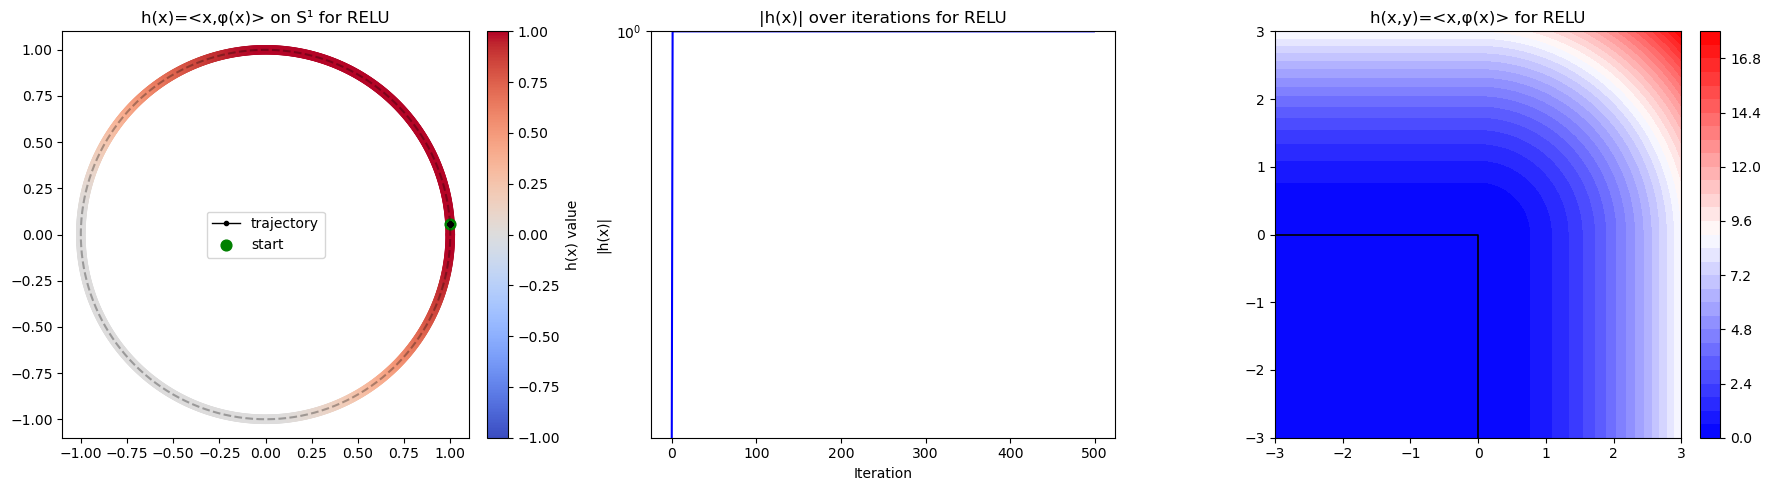

In [16]:
seed = np.random.randint(1000000)

phi, dphi = RELU, dRELU
x_star, h_val, h_hist = optimise_vanishing_set(phi=phi, dphi=dphi, n=2, seed=seed, steps=3000, lr=0.01, tol=1e-8)
print("x* on sphere:", x_star)
print("<x*, f(x*)> =", h_val)

plot_vanishing_set(phi=phi, dphi=dphi, name=phi.__name__, n_points=1000, eps=1e-8, seed=seed)

# Grid of plots

In [ ]:
def plot_vanishing_set_to_axes(axs_row, phi, dphi, name="activation",
                               n_points=400, eps=1e-8, seed=0):
    
    rng = np.random.default_rng(seed)

    # === (1) Sample h(x) on the unit circle ===
    theta = np.linspace(0, 2*np.pi, n_points)
    circle = np.c_[np.cos(theta), np.sin(theta)]
    hvals = np.array([np.dot(p, phi(p)) for p in circle])
    vmax = np.max(np.abs(hvals))

    # === (2) Optimisation (trajectory + convergence) ===
    def h(x): return float(np.dot(x, phi(x)))
    def grad_h(x): return phi(x) + dphi(x) * x
    def proj_tangent(x, v): return v - x * np.dot(x, v)
    def step_on_sphere(x, g, eta):
        y = x - eta * g
        return y / np.linalg.norm(y)

    x = rng.normal(size=2)
    x /= np.linalg.norm(x)
    start_point = x.copy()
    traj = [x.copy()]
    lr = 0.1
    for _ in range(500):
        hx = h(x)
        g_euc = grad_h(x)
        g_sph = hx * proj_tangent(x, g_euc)
        x = step_on_sphere(x, g_sph, lr)
        traj.append(x.copy())
    traj = np.array(traj)

    # === (3) Contour map ===
    xs = np.linspace(-3, 3, 500)
    ys = np.linspace(-3, 3, 500)
    X, Y = np.meshgrid(xs, ys)
    Z = X * phi(X) + Y * phi(Y)
    vmax2 = np.max(np.abs(Z))

    # ---------------------------------------------------------------------
    # (1) Circle view with trajectory
    ax1 = axs_row[0]
    ax1.plot(circle[:, 0], circle[:, 1], 'k--', alpha=0.3)
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    scatter = ax1.scatter(circle[:, 0], circle[:, 1], c=hvals,
                          cmap='coolwarm', s=35, norm=norm)
    ax1.plot(traj[:, 0], traj[:, 1], 'k.-', lw=1, label="trajectory")
    ax1.scatter(start_point[0], start_point[1], c='green', s=60, marker='o', label="start")
    ax1.set_aspect('equal')
    ax1.set_title(name, fontsize=10)
    ax1.legend(fontsize=7)

    # (2) Contour map
    ax2 = axs_row[1]
    norm2 = TwoSlopeNorm(vmin=-vmax2, vcenter=0, vmax=vmax2)
    contour = ax2.contourf(X, Y, Z, levels=30, cmap='bwr', norm=norm2)
    ax2.contour(X, Y, Z, levels=[0], colors='k', linewidths=1.2)
    ax2.set_aspect('equal')
    ax2.set_title("h(x,y)=<x,φ(x)>", fontsize=9)

    return scatter, contour


def plot_activation_grid(activations):
    n = len(activations)
    fig, axs = plt.subplots(2, n, figsize=(4*n, 8))
    plt.subplots_adjust(wspace=0.5, hspace=-0.05)

    for j, (name, phi, dphi) in enumerate(activations):
        sc, cont = plot_vanishing_set_to_axes(axs[:, j], phi, dphi, name)

        # Add colourbars beside each plot column
        fig.colorbar(sc, ax=axs[0, j], fraction=0.046, pad=0.04)
        fig.colorbar(cont, ax=axs[1, j], fraction=0.046, pad=0.04)

    plt.savefig("outputs/c_n activation func classification.png", dpi=300, bbox_inches='tight')
    plt.show()


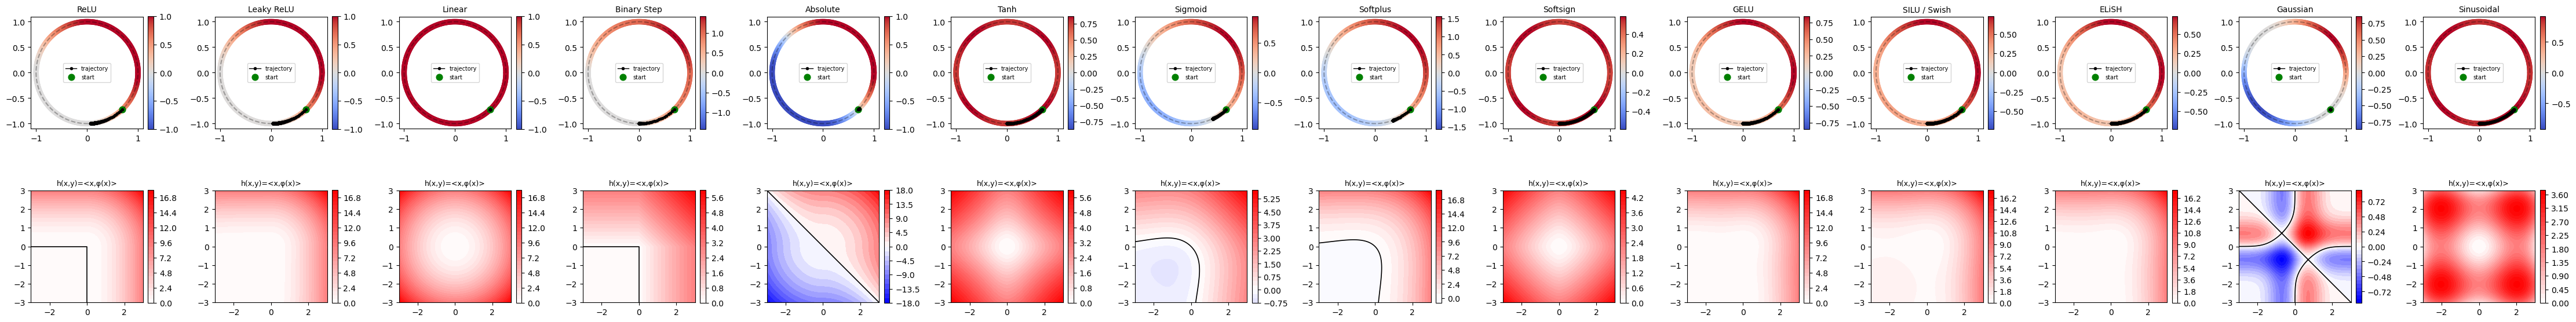

In [20]:
activations = [
    ("ReLU", RELU, dRELU),
    ("Leaky ReLU", LEAKY_RELU, dLEAKY_RELU),
    ("Linear", LINEAR, dLINEAR),
    ("Binary Step", BINARY, dBINARY),
    ("Absolute", ABS, dABS),
    ("Tanh", TANH, dTANH),
    ("Sigmoid", SIGMOID, dSIGMOID),
    ("Softplus", SOFTPLUS, dSOFTPLUS),
    ("Softsign", SOFTSIGN, dSOFTSIGN),
    ("GELU", GELU, dGELU),
    ("SILU / Swish", SILU, dSILU),
    ("ELiSH", ELISH, dELISH),
    ("Gaussian", GAUSSIAN, dGAUSSIAN),
    ("Sinusoidal", SINUSOIDAL, dSINUSOIDAL),
]
plot_activation_grid(activations)

Classification

Type I: Homogeneous $\deg 1$ functions: e.g. ReLU, Linear, Leaky ReLU | vanishing set includes entire regions

Type II: Odd functions: e.g. Tanh, GeLU, Softsign | vanishing set is trivial

Type III: Smooth non-homogoenous: e.g. Sigmoid, Softplus | antipodal vanishing sets


# Tropical Activation Optimisation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TropicalActivation(nn.Module):
    """Parameterised piecewise-linear activation φ(x) = max_k (a_k * x + b_k)."""
    def __init__(self, K=3):
        super().__init__()
        self.a = nn.Parameter(torch.randn(K))  # slopes
        self.b = nn.Parameter(torch.randn(K))  # intercepts

    def forward(self, x):
        # shape: (batch, K) -> max over K linear pieces
        return torch.max(self.a * x[..., None] + self.b, dim=-1).values

def sample_sphere(batch_size=512, n=10):
    x = torch.randn(batch_size, n)
    x /= x.norm(dim=1, keepdim=True)
    return x

def h_theta(phi, x):
    """Compute h(x) = <x, φ(x)>."""
    return (x * phi(x)).sum(dim=1)

def loss_fn(phi, eps=0.05, n=10, batch=512, lambda_reg=0.01):
    """Loss function for Gaussian loss:
        L = -E[exp(-h_theta(x)^2 / (2*eps^2))]
    """
    x = sample_sphere(batch, n)
    h = h_theta(phi, x)
    main_term = -torch.exp(-h**2 / (2 * eps**2)).mean()
    reg = lambda_reg * (phi.a.pow(2).mean() + phi.b.pow(2).mean())
    return main_term + reg

def loss_fn(phi, c=0.1, n=10, batch=512, lambda_reg=0.01):
    """
    Monte Carlo estimate of surface-area loss:
        L = -E[min(|h_theta(x)|, c)]
    """
    x = sample_sphere(batch, n)
    h = h_theta(phi, x)

    # --- main loss: truncated absolute value ---
    main_term = -torch.clamp(h.abs(), max=c).mean()

    # --- mild regularisation on parameters to avoid trivial collapse ---
    reg = lambda_reg * (phi.a.pow(2).mean() + phi.b.pow(2).mean())

    return main_term + reg



0000  loss=-0.0168
0100  loss=-0.0409
0200  loss=-0.1798
0300  loss=-0.9993
0400  loss=-0.9994
0500  loss=-0.9995
0600  loss=-0.9995
0700  loss=-0.9996
0800  loss=-0.9997
0900  loss=-0.9997
1000  loss=-0.9997
1100  loss=-0.9998
1200  loss=-0.9998
1300  loss=-0.9998
1400  loss=-0.9998
1500  loss=-0.9999
1600  loss=-0.9999
1700  loss=-0.9999
1800  loss=-0.9999
1900  loss=-0.9999


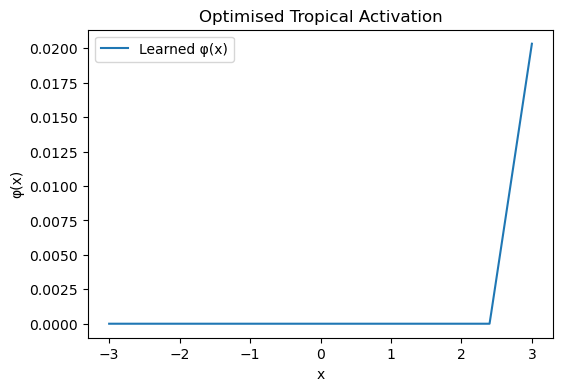

Approx. vanishing proportion: 1.000


In [32]:
phi = TropicalActivation(K=5)
opt = torch.optim.Adam(phi.parameters(), lr=1e-2)

for step in range(2000):
    loss = loss_fn(phi)
    loss.backward()
    opt.step()
    opt.zero_grad()
    if step % 100 == 0:
        print(f"{step:04d}  loss={loss.item():.4f}")

# plot learned activation
xs = torch.linspace(-3, 3, 500)
ys = phi(xs)
plt.figure(figsize=(6,4))
plt.plot(xs, ys.detach(), label="Learned φ(x)")
plt.title("Optimised Tropical Activation")
plt.xlabel("x"); plt.ylabel("φ(x)"); plt.legend()
plt.show()

# compute vanishing probability
x = sample_sphere(20000, n=10)
h = h_theta(phi, x)
p_vanish = (h.abs() < 0.05).float().mean().item()
print(f"Approx. vanishing proportion: {p_vanish:.3f}")
